In [77]:
# import library
import pandas as pd
import numpy as np 
import matlab 
import matplotlib.pyplot as plt
import os
import numpy as np
from gc import callbacks
import scipy.linalg as la
from sklearn import preprocessing
from distfit import distfit
from sklearn.decomposition import PCA
import sys 
from scipy.optimize import curve_fit
import scipy.constants as constants 


In [78]:
# read the file
# mortality
zipped = True
if zipped:
    mdf_path = r'data/mdf_final.csv'
    mdf = pd.read_csv(mdf_path, low_memory=False)
    mdf = mdf.drop(columns='Unnamed: 0')
    
    pdf_path = r'data\pdf_final.csv'
    pdf = pd.read_csv(pdf_path, low_memory=False)
    pdf = pdf.drop(columns=['Lb', 'Unnamed: 0'])
    
    lnmrdf = pd.read_csv(r'data/lnmr_final.csv', low_memory=False)
    lnmrdf = lnmrdf.drop(columns='Unnamed: 0')
    
    lnfrdf = pd.read_csv(r'data/lnfr_final.csv', low_memory=False)
    lnfrdf = lnfrdf.drop(columns='Unnamed: 0')
    
    
else:
    mortality_path_7 = r'data/MortIcd7.csv'
    mortality_data_7 = pd.read_csv(mortality_path_7, low_memory=False)

    mortality_path_8 = r'data/MortIcd8.csv'
    mortality_data_8 = pd.read_csv(mortality_path_8, low_memory=False)

    mortality_path_9 = r'data/Morticd9.csv'
    mortality_data_9 = pd.read_csv(mortality_path_9, low_memory=False)

    mortality_path_2002 = r'data/Morticd10_part1.csv'
    mortality_data_2002 = pd.read_csv(mortality_path_2002, low_memory=False)

    mortality_path_2007 = r'data/Morticd10_part2.csv'
    mortality_data_2007 = pd.read_csv(mortality_path_2007, low_memory=False)

    mortality_path_2012 = r'data/Morticd10_part3.csv'
    mortality_data_2012 = pd.read_csv(mortality_path_2012, low_memory=False)

    mortality_path_2016 = r'data/Morticd10_part4.csv'
    mortality_data_2016 = pd.read_csv(mortality_path_2016, low_memory=False)

    mdf = pd.concat([mortality_data_7, mortality_data_8, mortality_data_9, mortality_data_2002, mortality_data_2007, mortality_data_2012, mortality_data_2016], ignore_index=True)
    undesired_mortality_columns = ['Admin1', 'SubDiv', 'Sex', 'List', 'Frmat', 'IM_Frmat', 'Cause', 'IM_Deaths1','IM_Deaths2', 'IM_Deaths3', 'IM_Deaths4'] 
    mdf = mdf.drop(columns = undesired_mortality_columns)

    # population
    pop_path = r'data/pop.csv'
    pdf = pd.read_csv(pop_path, low_memory=False)
    dropped = False
    if not dropped:
        undesired_population_columns = ['Admin1', 'SubDiv', 'Sex', 'Frmat', 'Lb'] 
        pdf = pdf.drop(columns = undesired_population_columns)

# country code
country_code_path = r'data/country_codes.csv'
country_code = pd.read_csv(country_code_path, low_memory=False)
# creating the country code map 
country_code_map = {}
for index, rows in country_code.iterrows():
    country_code_map[rows['country']] = rows['name']

In [79]:
# needs to swap out the nah columns into averages 
done = True
if not done:
    not_used_country_list = []
    country_num_count = 0
    not_useful = False
    for key in country_code_map:
        country_num_count += 1
        display(country_num_count / len(country_code_map))
        country_mdf = mdf[mdf['Country'] == key]
        
        if country_mdf.empty:
            not_used_country_list.append(key)
        
        else:
            min_year = int(country_mdf['Year'].min())
            max_year = int(country_mdf['Year'].max()) 
            for i in range (min_year, max_year + 1):
                
                if not_useful:
                    break
                
                mask = (mdf['Country'] == key) & (mdf['Year'] == i)
                curr_Year = i

                for c in mdf.columns.values:
                    
                    if not_useful:
                        break
                    
                    average = mdf.loc[mask, c].mean()   
                    
                    max_iter = max_year - curr_Year
                    count = 0 
                    while np.isnan(average):
                        curr_Year += 1
                        count += 1
                        mask_alt = (mdf['Country'] == key) & (mdf['Year'] == curr_Year) 
                        average = mdf.loc[mask_alt, c].mean()   
                        
                        if count > max_iter:
                            not_useful = True
                            break 
                        
                        
                    mdf.loc[mask, c] = mdf.loc[mask, c].fillna(average)
                    curr_Year = i 
                    
            if not_useful:
                display(key)
                not_used_country_list.append(key)
                index = mdf[mdf['Country'] == key].index
                mdf = mdf.drop(index)
                not_useful = False
                
    undesired_mortality_columns = ['Admin1', 'SubDiv', 'Sex', 'List', 'Frmat', 'IM_Frmat', 'Cause', 'IM_Deaths1','IM_Deaths2', 'IM_Deaths3', 'IM_Deaths4'] 
    mdf = mdf.drop(columns = undesired_mortality_columns)            
    mdf = mdf.groupby(['Country', 'Year'], as_index=True).agg("sum").reset_index()
    
    # building the potential country list 
    country_list = list(set(mdf['Country']))
    country_list.sort()
    len(country_list) 
        
            

        

In [80]:
# build pdf
done = True
if not done:
    not_used_pop_list = []
    country_num_count = 0
    not_useful = False
    for key in country_list:
        
            country_num_count += 1
            display(country_num_count / len(country_list))
            
            country_pdf = pdf[pdf['Country'] == key]
            
            if country_pdf.empty:
                not_used_pop_list.append(key)
            
            else:
                min_year = int(country_pdf['Year'].min())
                max_year = int(country_pdf['Year'].max()) 
                
                if min_year == max_year:
                    if (country_pdf.isnull().sum().sum() > 0):
                        not_useful = True
                    else:
                        continue
                
                for i in range (min_year, max_year + 1):
                    
                    if not_useful:
                        break
                    
                    mask = (pdf['Country'] == key) & (pdf['Year'] == i)
                    curr_Year = i

                    for c in pdf.columns.values:
                        
                        if not_useful:
                            break
                        
                        average = pdf.loc[mask, c].mean()   
                        
                        max_iter = max_year - curr_Year
                        count = 0 
                        while np.isnan(average):
                            curr_Year += 1
                            count += 1
                            mask_alt = (pdf['Country'] == key) & (pdf['Year'] == curr_Year)
                            average = pdf.loc[mask_alt, c].mean()   
                            
                            if count > max_iter:
                                not_useful = True
                                break 
                            
                            
                        pdf.loc[mask, c] = pdf.loc[mask, c].fillna(average)
                        curr_Year = i 
                        
                if not_useful:
                    display(key)
                    not_used_pop_list.append(key)
                    index = pdf[pdf['Country'] == key].index
                    pdf = pdf.drop(index)
                    not_useful = False
                    
    # delete the unused countries 
    for key in not_used_pop_list:
        country_list.remove(key)
        
    # finalizing pdf 
    pdf = pdf[pdf['Country'].isin(country_list)]
    pdf = pdf.groupby(['Country', 'Year'], as_index=True).agg("sum").reset_index()
    pdf.to_csv(r'data/pdf_final.csv')
    
    # finalizing mdf 
    mdf = mdf[mdf['Country'].isin(country_list)]
    mdf.to_csv(r'data/mdf_final.csv')
                    
                
        
    

In [81]:
# create the log mortality rate graph 

done = True
if not done:
    
    lnmr_dict = {}
    lnmr_dict['Country'] = []
    lnmr_dict['Year'] = []
    for i in range (6, 27):
        lnmr_column = f'Log Mortality{i}'
        lnmr_dict[lnmr_column] = []
    
    lnmrdf = pd.DataFrame(lnmr_dict)
    
    country_list = list(set(mdf['Country']))
    country_list.sort()
    
    country_num_count = 0
    for key in country_list:
        
        country_num_count += 1
        display(country_num_count / len(country_list))
        
        country_mdf = mdf[mdf['Country'] == key]
        min_year = int(country_mdf['Year'].min())
        max_year = int(country_mdf['Year'].max()) 
        
        for i in range (min_year, max_year + 1):
            
            m_mask = (mdf['Country'] == key) & (mdf['Year'] == i)
            p_mask = (pdf['Country'] == key) & (pdf['Year'] == i)
            
            if pdf[p_mask].empty or mdf[m_mask].empty:
                continue
            else:
                lnmrdf.loc[lnmrdf.shape[0]] = ['None'] * lnmrdf.shape[1]
                lnmrdf.loc[lnmrdf.shape[0]-1, ['Country']] = key
                lnmrdf.loc[lnmrdf.shape[0]-1, ['Year']] = i
            
            for c in range(6, 27):
                
                if c == 6:
                    deaths = 0
                    population = 0
                    for j in range (2, 7):
                        m_column = f'Deaths{c}'
                        p_column = f'Pop{c}'
                        lnmr_column = f'Log Mortality{c}'
                        try:
                            deaths += mdf[m_mask][m_column].values.astype('float')[0]
                            population += pdf[p_mask][p_column].values.astype('float')[0]
                        except:
                            display(key)
                            display(i)
                            display(c)
                            callbacks()
                else:
                    m_column = f'Deaths{c}'
                    p_column = f'Pop{c}'
                    lnmr_column = f'Log Mortality{c}'
                    try:
                        deaths = mdf[m_mask][m_column].values.astype('float')[0]
                        population = pdf[p_mask][p_column].values.astype('float')[0]
                    except:
                        display(key)
                        display(i)
                        display(c)
                        callbacks()
                try:
                    ratio = deaths / population
                    lnmrdf.loc[lnmrdf.shape[0]-1, lnmr_column] = np.log(ratio)
                except:
                    display(key)
                    display(i)
                    display(c)
                    callbacks()
    
    lnmrdf.to_csv(r'data/lnmr_final.csv')

In [82]:
# fit the mortality model 
from numpy import inf


done = False
pred_year = 2050
each_country_num = 50
if not done:
    
    country_list = list(set(lnmrdf['Country']))
    country_list.sort()
    mort_d = {}
    
    for key in country_list:
        
        try: 
        
            display(key)
            c_s = []
            
            country_lnmrdf = lnmrdf[lnmrdf['Country'] == key]
            min_year = int(country_lnmrdf['Year'].min())
            max_year = int(country_lnmrdf['Year'].max())
            
            ma = country_lnmrdf[country_lnmrdf['Year'] > min_year].drop(columns=['Country', 'Year']).values
            mb = country_lnmrdf[country_lnmrdf['Year'] < max_year].drop(columns=['Country', 'Year']).values

            m = np.nan_to_num(ma - mb)
            scaler = preprocessing.StandardScaler().fit(m)
            m_scaled = np.nan_to_num(scaler.transform(m))
            u, singular, V_transpose = np.linalg.svd(m_scaled)
            singular[singular == inf] = sys.float_info.max
            dist = distfit()
            # gamma distribution 
            dist.fit_transform(singular)
            # loading vectors
            pca = PCA(n_components=1)
            transformed_data = pca.fit(m_scaled).transform(m_scaled)
            eigenValues = pca.explained_variance_ratio_
            # loading = pca.components_.T * np.sqrt(pca.explained_variance_)
            loadings = pd.DataFrame(pca.components_.T)
            lv = np.matrix(loadings[0].values)
            y = int((pred_year - max_year)) 
            for i in range (each_country_num):    
                m_new = np.matrix(dist.generate(y)).reshape(y, 1)
                pred = m_new * lv
                c_s.append(pred)
                
            mort_d[key] = c_s
        
        except:
            continue

2140

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.00613154] [loc=4.948 scale=3.558]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00384375] [loc=0.000 scale=4.948]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.0291817] [loc=-0.000 scale=0.000]
[distfit] >INFO> [dweibull  ] [0.04 sec] [RSS: 0.00543852] [loc=4.421 scale=2.790]
[distfit] >INFO> [t         ] [0.35 sec] [RSS: 0.00557613] [loc=4.785 scale=3.569]
[distfit] >INFO> [genextreme] [0.11 sec] [RSS: 0.00177029] [loc=3.296 scale=2.733]
[distfit] >INFO> [gamma     ] [0.02 sec] [RSS: 0.00100171] [loc=-0.932 scale=2.363]
[distfit] >INFO> [lognorm   ] [0.09 sec] [RSS: 0.00143144] [loc=-3.711 scale=7.980]
[distfit] >INFO> [beta      ] [0.19 sec] [RSS: 0.00251999] [loc=-0.000 scale=25.389]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0118355] [loc=0.000 scale=14.740]
[distfit] >INFO> [loggamma  ] [0.12 sec] [RSS: 0.00618902] [loc=-1145.470 scale=153.872]
[distfit] >INFO> Compute conf

3080

[distfit] >INFO> fit
[distfit] >INFO> transform


3160

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.0258671] [loc=4.668 scale=6.409]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.0029875] [loc=0.000 scale=4.668]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.00124493] [loc=-14.390 scale=14.390]
[distfit] >INFO> [dweibull  ] [0.08 sec] [RSS: 0.0101404] [loc=2.076 scale=2.642]
[distfit] >INFO> [t         ] [0.17 sec] [RSS: 0.0038128] [loc=2.185 scale=1.201]
[distfit] >INFO> [genextreme] [0.13 sec] [RSS: 0.00165756] [loc=1.938 scale=1.842]
[distfit] >INFO> [gamma     ] [0.17 sec] [RSS: 0.00523511] [loc=-0.000 scale=1.867]
[distfit] >INFO> [lognorm   ] [0.05 sec] [RSS: 0.00110875] [loc=-0.350 scale=3.119]
[distfit] >INFO> [beta      ] [0.32 sec] [RSS: 0.00264085] [loc=-0.000 scale=1771.229]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0397502] [loc=0.000 scale=30.366]
[distfit] >INFO> [loggamma  ] [0.20 sec] [RSS: 0.0265926] [loc=-2567.932 scale=330.704]
[distfit] >INFO> Compute conf

3325

[distfit] >INFO> fit
[distfit] >INFO> transform


3400

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.0048435] [loc=3.547 scale=2.724]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.0138451] [loc=0.000 scale=3.547]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.0405335] [loc=-0.003 scale=0.003]
[distfit] >INFO> [dweibull  ] [0.12 sec] [RSS: 0.00560509] [loc=2.436 scale=2.432]
[distfit] >INFO> [t         ] [0.25 sec] [RSS: 0.00257482] [loc=2.834 scale=1.652]
[distfit] >INFO> [genextreme] [0.16 sec] [RSS: 0.00339905] [loc=2.253 scale=2.004]
[distfit] >INFO> [gamma     ] [0.19 sec] [RSS: 0.0214892] [loc=0.000 scale=7.094]
[distfit] >INFO> [lognorm   ] [0.16 sec] [RSS: 0.00408224] [loc=-2.439 scale=5.418]
[distfit] >INFO> [beta      ] [0.37 sec] [RSS: 0.0272287] [loc=0.000 scale=10.877]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0107058] [loc=0.000 scale=9.158]
[distfit] >INFO> [loggamma  ] [0.16 sec] [RSS: 0.00498096] [loc=-762.268 scale=104.998]
[distfit] >INFO> Compute confidence i

4010

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.01 sec] [RSS: 0.00902119] [loc=5.178 scale=5.593]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00108533] [loc=0.000 scale=5.178]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.00119948] [loc=-95.992 scale=95.992]
[distfit] >INFO> [dweibull  ] [0.11 sec] [RSS: 0.0182704] [loc=4.444 scale=2.854]
[distfit] >INFO> [t         ] [0.17 sec] [RSS: 0.00555047] [loc=3.800 scale=2.403]
[distfit] >INFO> [genextreme] [0.11 sec] [RSS: 0.00106195] [loc=2.739 scale=2.334]
[distfit] >INFO> [gamma     ] [0.15 sec] [RSS: 0.0112466] [loc=-0.000 scale=1.733]
[distfit] >INFO> [lognorm   ] [0.07 sec] [RSS: 0.000940771] [loc=-0.828 scale=4.527]
[distfit] >INFO> [beta      ] [0.21 sec] [RSS: 0.0022304] [loc=-0.000 scale=559.275]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0209767] [loc=0.000 scale=27.441]
[distfit] >INFO> [loggamma  ] [0.11 sec] [RSS: 0.00949902] [loc=-1989.014 scale=262.021]
[distfit] >INFO> Compute co

4020

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.0112439] [loc=5.132 scale=5.720]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00105259] [loc=0.000 scale=5.132]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.00112153] [loc=-65.747 scale=65.747]
[distfit] >INFO> [dweibull  ] [0.08 sec] [RSS: 0.0112479] [loc=3.737 scale=3.102]
[distfit] >INFO> [t         ] [0.17 sec] [RSS: 0.00921229] [loc=3.675 scale=2.337]
[distfit] >INFO> [genextreme] [0.28 sec] [RSS: 0.00164791] [loc=2.651 scale=2.322]
[distfit] >INFO> [gamma     ] [0.18 sec] [RSS: 0.00148305] [loc=-0.000 scale=6.579]
[distfit] >INFO> [lognorm   ] [0.12 sec] [RSS: 0.00128307] [loc=-0.775 scale=4.365]
[distfit] >INFO> [beta      ] [0.22 sec] [RSS: 0.00123132] [loc=-0.000 scale=278.678]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0239564] [loc=0.000 scale=28.012]
[distfit] >INFO> [loggamma  ] [0.13 sec] [RSS: 0.0121132] [loc=-1969.495 scale=261.875]
[distfit] >INFO> Compute con

4030

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.00986377] [loc=4.855 scale=5.095]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.000868043] [loc=0.000 scale=4.855]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.000877364] [loc=-132.233 scale=132.233]
[distfit] >INFO> [dweibull  ] [0.13 sec] [RSS: 0.00515006] [loc=2.920 scale=2.783]
[distfit] >INFO> [t         ] [0.13 sec] [RSS: 0.00582147] [loc=3.187 scale=1.994]
[distfit] >INFO> [genextreme] [0.12 sec] [RSS: 0.00164668] [loc=2.563 scale=2.153]
[distfit] >INFO> [gamma     ] [0.17 sec] [RSS: 0.00959739] [loc=-0.000 scale=1.733]
[distfit] >INFO> [lognorm   ] [0.14 sec] [RSS: 0.00122979] [loc=-0.756 scale=4.235]
[distfit] >INFO> [beta      ] [0.27 sec] [RSS: 0.000839063] [loc=-0.042 scale=6397111.945]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0214382] [loc=0.000 scale=24.390]
[distfit] >INFO> [loggamma  ] [0.16 sec] [RSS: 0.0104365] [loc=-2285.801 scale=288.135]
[distfit] >INFO> 

4038

[distfit] >INFO> fit
[distfit] >INFO> transform


4045

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.0299825] [loc=3.098 scale=4.015]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00135648] [loc=0.000 scale=3.098]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.00136486] [loc=-9.158 scale=9.158]
[distfit] >INFO> [dweibull  ] [0.19 sec] [RSS: 0.00559897] [loc=1.534 scale=2.098]
[distfit] >INFO> [t         ] [0.11 sec] [RSS: 0.00778458] [loc=1.889 scale=1.654]
[distfit] >INFO> [genextreme] [0.08 sec] [RSS: 0.00226123] [loc=1.155 scale=1.392]
[distfit] >INFO> [gamma     ] [0.13 sec] [RSS: 0.00669147] [loc=-0.000 scale=1.849]
[distfit] >INFO> [lognorm   ] [0.07 sec] [RSS: 0.00211335] [loc=-0.215 scale=1.830]
[distfit] >INFO> [beta      ] [0.20 sec] [RSS: 0.00379735] [loc=-0.000 scale=900.473]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0561336] [loc=0.000 scale=18.799]
[distfit] >INFO> [loggamma  ] [0.11 sec] [RSS: 0.0317578] [loc=-989.113 scale=141.668]
[distfit] >INFO> Compute confi

4050

[distfit] >INFO> fit
[distfit] >INFO> transform


4055

[distfit] >INFO> fit
[distfit] >INFO> transform


4084

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.0164027] [loc=3.582 scale=3.846]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00258596] [loc=0.000 scale=3.582]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.00297247] [loc=-55.996 scale=55.996]
[distfit] >INFO> [dweibull  ] [0.05 sec] [RSS: 0.0101982] [loc=2.443 scale=3.038]
[distfit] >INFO> [t         ] [0.11 sec] [RSS: 0.00432341] [loc=2.474 scale=1.642]
[distfit] >INFO> [genextreme] [0.13 sec] [RSS: 0.00244407] [loc=1.767 scale=1.715]
[distfit] >INFO> [gamma     ] [0.17 sec] [RSS: 0.00548159] [loc=-0.000 scale=5.728]
[distfit] >INFO> [lognorm   ] [0.08 sec] [RSS: 0.00310004] [loc=-0.543 scale=2.959]
[distfit] >INFO> [beta      ] [0.24 sec] [RSS: 0.00415301] [loc=-0.000 scale=461.960]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0386966] [loc=0.000 scale=17.946]
[distfit] >INFO> [loggamma  ] [0.14 sec] [RSS: 0.0167811] [loc=-1277.840 scale=169.663]
[distfit] >INFO> Compute con

4140

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.00898327] [loc=5.430 scale=5.259]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00524734] [loc=0.000 scale=5.430]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.00524734] [loc=-134217728.000 scale=134217728.000]
[distfit] >INFO> [dweibull  ] [0.05 sec] [RSS: 0.00461468] [loc=3.353 scale=2.938]
[distfit] >INFO> [t         ] [0.19 sec] [RSS: 0.00590492] [loc=3.979 scale=2.241]
[distfit] >INFO> [genextreme] [0.14 sec] [RSS: 0.00257391] [loc=3.136 scale=2.471]
[distfit] >INFO> [gamma     ] [0.19 sec] [RSS: 0.0340932] [loc=-0.000 scale=1.733]
[distfit] >INFO> [lognorm   ] [0.10 sec] [RSS: 0.00260516] [loc=-1.171 scale=5.315]
[distfit] >INFO> [beta      ] [0.19 sec] [RSS: 0.00299156] [loc=-0.200 scale=181372031999.609]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0227746] [loc=0.000 scale=25.809]
[distfit] >INFO> [loggamma  ] [0.15 sec] [RSS: 0.00957519] [loc=-1629.713 scale=221.333]
[di

4160

[distfit] >INFO> fit
[distfit] >INFO> transform


4170

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.00464396] [loc=5.779 scale=5.157]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00306486] [loc=0.000 scale=5.779]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.00306486] [loc=-536870912.000 scale=536870912.000]
[distfit] >INFO> [dweibull  ] [0.20 sec] [RSS: 0.00724242] [loc=4.685 scale=3.200]
[distfit] >INFO> [t         ] [0.13 sec] [RSS: 0.00339025] [loc=4.707 scale=2.598]
[distfit] >INFO> [genextreme] [0.12 sec] [RSS: 0.00097308] [loc=3.522 scale=2.697]
[distfit] >INFO> [gamma     ] [0.14 sec] [RSS: 0.0226616] [loc=-0.000 scale=1.733]
[distfit] >INFO> [lognorm   ] [0.11 sec] [RSS: 0.000943609] [loc=-1.578 scale=6.168]
[distfit] >INFO> [beta      ] [0.25 sec] [RSS: 0.0011817] [loc=-0.278 scale=82540057445.407]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0154629] [loc=0.000 scale=25.609]
[distfit] >INFO> [loggamma  ] [0.13 sec] [RSS: 0.00514773] [loc=-2617.889 scale=321.620]
[dis

4180

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.0263881] [loc=4.679 scale=6.325]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00249208] [loc=0.000 scale=4.679]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.00112692] [loc=-16.978 scale=16.978]
[distfit] >INFO> [dweibull  ] [0.11 sec] [RSS: 0.00780702] [loc=1.940 scale=2.804]
[distfit] >INFO> [t         ] [0.12 sec] [RSS: 0.00710445] [loc=2.353 scale=1.468]
[distfit] >INFO> [genextreme] [0.11 sec] [RSS: 0.00132711] [loc=2.026 scale=1.867]
[distfit] >INFO> [gamma     ] [0.15 sec] [RSS: 0.00772957] [loc=-0.000 scale=1.867]
[distfit] >INFO> [lognorm   ] [0.05 sec] [RSS: 0.000995477] [loc=-0.392 scale=3.263]
[distfit] >INFO> [beta      ] [0.20 sec] [RSS: 0.0018596] [loc=-0.000 scale=307.137]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.041788] [loc=0.000 scale=30.446]
[distfit] >INFO> [loggamma  ] [0.12 sec] [RSS: 0.0275384] [loc=-2028.879 scale=273.553]
[distfit] >INFO> Compute con

4182

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.0287242] [loc=3.281 scale=4.546]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.0032565] [loc=0.000 scale=3.281]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.00274051] [loc=-8.525 scale=8.525]
[distfit] >INFO> [dweibull  ] [0.06 sec] [RSS: 0.00687401] [loc=0.987 scale=1.991]
[distfit] >INFO> [t         ] [0.08 sec] [RSS: 0.00425588] [loc=1.570 scale=1.298]
[distfit] >INFO> [genextreme] [0.08 sec] [RSS: 0.00554032] [loc=1.205 scale=1.284]
[distfit] >INFO> [gamma     ] [0.12 sec] [RSS: 0.00754983] [loc=-0.000 scale=1.851]
[distfit] >INFO> [lognorm   ] [0.02 sec] [RSS: 0.00314982] [loc=-0.174 scale=1.961]
[distfit] >INFO> [beta      ] [0.12 sec] [RSS: 0.00372708] [loc=-0.000 scale=285.164]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0505998] [loc=0.000 scale=21.555]
[distfit] >INFO> [loggamma  ] [0.08 sec] [RSS: 0.0291724] [loc=-1217.530 scale=169.453]
[distfit] >INFO> Compute confi

4186

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.0391201] [loc=3.275 scale=4.487]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00389017] [loc=0.000 scale=3.275]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.00175906] [loc=-8.420 scale=8.420]
[distfit] >INFO> [dweibull  ] [0.03 sec] [RSS: 0.00590852] [loc=1.428 scale=2.233]
[distfit] >INFO> [t         ] [0.06 sec] [RSS: 0.012736] [loc=1.915 scale=1.656]
[distfit] >INFO> [genextreme] [0.06 sec] [RSS: 0.0014367] [loc=1.213 scale=1.443]
[distfit] >INFO> [gamma     ] [0.10 sec] [RSS: 0.00532591] [loc=-0.000 scale=1.733]
[distfit] >INFO> [lognorm   ] [0.03 sec] [RSS: 0.00168019] [loc=-0.238 scale=1.945]
[distfit] >INFO> [beta      ] [0.17 sec] [RSS: 0.00209651] [loc=-0.000 scale=314.431]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0633575] [loc=0.000 scale=21.311]
[distfit] >INFO> [loggamma  ] [0.10 sec] [RSS: 0.0408934] [loc=-1339.050 scale=183.710]
[distfit] >INFO> Compute confide

4188

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.0173835] [loc=3.752 scale=4.165]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00123302] [loc=0.000 scale=3.752]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.00131877] [loc=-36.558 scale=36.558]
[distfit] >INFO> [dweibull  ] [0.04 sec] [RSS: 0.0105897] [loc=2.575 scale=2.877]
[distfit] >INFO> [t         ] [0.11 sec] [RSS: 0.00376916] [loc=2.316 scale=1.754]
[distfit] >INFO> [genextreme] [0.12 sec] [RSS: 0.00351771] [loc=1.715 scale=1.634]
[distfit] >INFO> [gamma     ] [0.03 sec] [RSS: 0.00103203] [loc=-0.042 scale=3.067]
[distfit] >INFO> [lognorm   ] [0.04 sec] [RSS: 0.00218018] [loc=-0.373 scale=2.807]
[distfit] >INFO> [beta      ] [0.11 sec] [RSS: 0.00140296] [loc=-0.000 scale=4076.848]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0350735] [loc=0.000 scale=19.284]
[distfit] >INFO> [loggamma  ] [0.07 sec] [RSS: 0.0177228] [loc=-1829.114 scale=229.514]
[distfit] >INFO> Compute co

4190

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.00268642] [loc=5.428 scale=4.277]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00262285] [loc=0.000 scale=5.428]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.0142187] [loc=-0.037 scale=0.037]
[distfit] >INFO> [dweibull  ] [0.01 sec] [RSS: 0.00169188] [loc=4.512 scale=3.654]
[distfit] >INFO> [t         ] [0.16 sec] [RSS: 0.00257027] [loc=5.321 scale=4.105]
[distfit] >INFO> [genextreme] [0.12 sec] [RSS: 0.000589601] [loc=3.465 scale=3.458]
[distfit] >INFO> [gamma     ] [0.10 sec] [RSS: 0.00789054] [loc=-0.000 scale=4.287]
[distfit] >INFO> [lognorm   ] [0.17 sec] [RSS: 0.020604] [loc=-0.000 scale=1.969]
[distfit] >INFO> [beta      ] [0.16 sec] [RSS: 0.00627587] [loc=-0.000 scale=53.594]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.00759525] [loc=0.000 scale=16.555]
[distfit] >INFO> [loggamma  ] [0.10 sec] [RSS: 0.0027598] [loc=-1372.741 scale=184.118]
[distfit] >INFO> Compute confi

4195

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.0108401] [loc=3.533 scale=3.221]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00427962] [loc=0.000 scale=3.533]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.00427962] [loc=-67108864.000 scale=67108864.000]
[distfit] >INFO> [dweibull  ] [0.01 sec] [RSS: 0.00647937] [loc=3.031 scale=2.316]
[distfit] >INFO> [t         ] [0.08 sec] [RSS: 0.0056344] [loc=2.909 scale=1.967]
[distfit] >INFO> [genextreme] [0.07 sec] [RSS: 0.00146446] [loc=1.982 scale=1.808]
[distfit] >INFO> [gamma     ] [0.09 sec] [RSS: 0.00465169] [loc=-0.000 scale=3.781]
[distfit] >INFO> [lognorm   ] [0.06 sec] [RSS: 0.00226928] [loc=-0.887 scale=3.527]
[distfit] >INFO> [beta      ] [0.15 sec] [RSS: 0.00699142] [loc=-0.000 scale=302.746]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0336448] [loc=0.000 scale=14.986]
[distfit] >INFO> [loggamma  ] [0.08 sec] [RSS: 0.0116286] [loc=-1481.209 scale=185.474]
[distfit] >INFO>

4200

[distfit] >INFO> fit
[distfit] >INFO> transform


4210

[distfit] >INFO> fit
[distfit] >INFO> transform


4220

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.00432621] [loc=5.775 scale=5.344]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00228865] [loc=0.000 scale=5.775]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.00228865] [loc=-134217728.000 scale=134217728.000]
[distfit] >INFO> [dweibull  ] [0.02 sec] [RSS: 0.00230165] [loc=4.749 scale=3.566]
[distfit] >INFO> [t         ] [0.12 sec] [RSS: 0.00221803] [loc=4.630 scale=2.900]
[distfit] >INFO> [genextreme] [0.06 sec] [RSS: 0.000610397] [loc=3.313 scale=2.853]
[distfit] >INFO> [gamma     ] [0.04 sec] [RSS: 0.0014445] [loc=-0.101 scale=4.592]
[distfit] >INFO> [lognorm   ] [0.04 sec] [RSS: 0.000846261] [loc=-1.485 scale=5.879]
[distfit] >INFO> [beta      ] [0.09 sec] [RSS: 0.00145193] [loc=-0.099 scale=8307725757.348]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0141397] [loc=0.000 scale=25.605]
[distfit] >INFO> [loggamma  ] [0.06 sec] [RSS: 0.00459165] [loc=-2213.351 scale=282.344]
[di

4230

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.0278785] [loc=4.193 scale=5.899]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00297858] [loc=0.000 scale=4.193]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.00185666] [loc=-10.559 scale=10.559]
[distfit] >INFO> [dweibull  ] [0.06 sec] [RSS: 0.293861] [loc=1.279 scale=2.218]
[distfit] >INFO> [t         ] [0.08 sec] [RSS: 0.00187794] [loc=1.833 scale=1.314]
[distfit] >INFO> [genextreme] [0.12 sec] [RSS: 0.00361901] [loc=1.606 scale=1.594]
[distfit] >INFO> [gamma     ] [0.11 sec] [RSS: 0.0073172] [loc=-0.000 scale=1.867]
[distfit] >INFO> [lognorm   ] [0.02 sec] [RSS: 0.00181535] [loc=-0.249 scale=2.608]
[distfit] >INFO> [beta      ] [0.13 sec] [RSS: 0.00850905] [loc=-0.000 scale=196.478]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0431503] [loc=0.000 scale=27.728]
[distfit] >INFO> [loggamma  ] [0.06 sec] [RSS: 0.0286868] [loc=-2505.687 scale=318.322]
[distfit] >INFO> Compute confi

4240

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.552612] [loc=2.506 scale=7.132]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.195413] [loc=0.000 scale=2.506]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.0244238] [loc=-1.156 scale=1.156]
[distfit] >INFO> [dweibull  ] [0.04 sec] [RSS: 0.046433] [loc=0.303 scale=0.625]
[distfit] >INFO> [t         ] [0.05 sec] [RSS: 0.0567248] [loc=0.464 scale=0.319]
[distfit] >INFO> [genextreme] [0.09 sec] [RSS: 0.0157861] [loc=0.460 scale=0.504]
[distfit] >INFO> [gamma     ] [0.08 sec] [RSS: 0.279427] [loc=-0.000 scale=18.276]
[distfit] >INFO> [lognorm   ] [0.03 sec] [RSS: 0.0208204] [loc=-0.034 scale=0.753]
[distfit] >INFO> [beta      ] [0.10 sec] [RSS: 0.157139] [loc=-0.000 scale=459.744]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.612713] [loc=0.000 scale=34.172]
[distfit] >INFO> [loggamma  ] [0.05 sec] [RSS: 0.557812] [loc=-2344.798 scale=313.976]
[distfit] >INFO> Compute confidence interva

4270

[distfit] >INFO> fit
[distfit] >INFO> transform


4272

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.0242817] [loc=3.701 scale=4.431]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00333501] [loc=0.000 scale=3.701]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.00187442] [loc=-11.534 scale=11.534]
[distfit] >INFO> [dweibull  ] [0.07 sec] [RSS: 0.00145558] [loc=1.579 scale=3.264]
[distfit] >INFO> [t         ] [0.05 sec] [RSS: 0.00389561] [loc=1.417 scale=1.194]
[distfit] >INFO> [genextreme] [0.05 sec] [RSS: 0.00167823] [loc=1.305 scale=1.437]
[distfit] >INFO> [gamma     ] [0.07 sec] [RSS: 0.00557734] [loc=-0.000 scale=6.022]
[distfit] >INFO> [lognorm   ] [0.03 sec] [RSS: 0.00114085] [loc=-0.170 scale=2.179]
[distfit] >INFO> [beta      ] [0.09 sec] [RSS: 0.00392052] [loc=-0.000 scale=194.160]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0379755] [loc=0.000 scale=19.200]
[distfit] >INFO> [loggamma  ] [0.07 sec] [RSS: 0.0245718] [loc=-911.904 scale=134.787]
[distfit] >INFO> Compute con

4273

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.00503453] [loc=3.714 scale=2.492]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.014732] [loc=0.000 scale=3.714]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.0679309] [loc=-0.000 scale=0.000]
[distfit] >INFO> [dweibull  ] [0.02 sec] [RSS: 0.00606045] [loc=3.150 scale=2.161]
[distfit] >INFO> [t         ] [0.15 sec] [RSS: 0.00503491] [loc=3.714 scale=2.492]
[distfit] >INFO> [genextreme] [0.05 sec] [RSS: 0.00558194] [loc=2.573 scale=2.029]
[distfit] >INFO> [gamma     ] [0.03 sec] [RSS: 0.00486418] [loc=-0.676 scale=1.602]
[distfit] >INFO> [lognorm   ] [0.05 sec] [RSS: 0.00550617] [loc=-2.900 scale=6.158]
[distfit] >INFO> [beta      ] [0.11 sec] [RSS: 0.00705796] [loc=0.000 scale=9.963]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0145249] [loc=0.000 scale=9.581]
[distfit] >INFO> [loggamma  ] [0.06 sec] [RSS: 0.0051292] [loc=-701.669 scale=96.622]
[distfit] >INFO> Compute confidence i

4274

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.0373632] [loc=2.946 scale=3.503]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00338798] [loc=0.000 scale=2.946]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.00204645] [loc=-15.011 scale=15.011]
[distfit] >INFO> [dweibull  ] [0.03 sec] [RSS: 0.0245566] [loc=1.880 scale=2.706]
[distfit] >INFO> [t         ] [0.10 sec] [RSS: 0.0116485] [loc=1.770 scale=1.437]
[distfit] >INFO> [genextreme] [0.07 sec] [RSS: 0.00230673] [loc=1.207 scale=1.282]
[distfit] >INFO> [gamma     ] [0.10 sec] [RSS: 0.00331097] [loc=-0.000 scale=1.867]
[distfit] >INFO> [lognorm   ] [0.05 sec] [RSS: 0.00145074] [loc=-0.208 scale=1.939]
[distfit] >INFO> [beta      ] [0.13 sec] [RSS: 0.00408254] [loc=-0.000 scale=252.950]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0641782] [loc=0.000 scale=16.187]
[distfit] >INFO> [loggamma  ] [0.07 sec] [RSS: 0.0387464] [loc=-1112.409 scale=150.592]
[distfit] >INFO> Compute conf

4280

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.020695] [loc=4.725 scale=6.215]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00290145] [loc=0.000 scale=4.725]
[distfit] >INFO> [pareto    ] [0.01 sec] [RSS: 0.00343214] [loc=-22.212 scale=22.212]
[distfit] >INFO> [dweibull  ] [0.15 sec] [RSS: 0.0125249] [loc=2.714 scale=4.811]
[distfit] >INFO> [t         ] [0.31 sec] [RSS: 0.00464879] [loc=2.683 scale=1.519]
[distfit] >INFO> [genextreme] [0.24 sec] [RSS: 0.00197539] [loc=2.231 scale=1.940]
[distfit] >INFO> [gamma     ] [0.24 sec] [RSS: 0.0169451] [loc=-0.000 scale=1.867]
[distfit] >INFO> [lognorm   ] [0.08 sec] [RSS: 0.00222044] [loc=-0.509 scale=3.585]
[distfit] >INFO> [beta      ] [0.23 sec] [RSS: 0.00363582] [loc=-0.000 scale=590.009]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0369249] [loc=0.000 scale=30.405]
[distfit] >INFO> [loggamma  ] [0.13 sec] [RSS: 0.0217248] [loc=-2233.364 scale=294.461]
[distfit] >INFO> Compute confi

4290

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.00645844] [loc=5.538 scale=5.589]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.000877454] [loc=0.000 scale=5.538]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.000890916] [loc=-817.818 scale=817.818]
[distfit] >INFO> [dweibull  ] [0.06 sec] [RSS: 0.00641266] [loc=4.426 scale=3.307]
[distfit] >INFO> [t         ] [0.15 sec] [RSS: 0.00424331] [loc=4.126 scale=2.681]
[distfit] >INFO> [genextreme] [0.07 sec] [RSS: 0.000842141] [loc=2.961 scale=2.589]
[distfit] >INFO> [gamma     ] [0.09 sec] [RSS: 0.0126954] [loc=-0.000 scale=1.733]
[distfit] >INFO> [lognorm   ] [0.04 sec] [RSS: 0.000810442] [loc=-0.953 scale=4.947]
[distfit] >INFO> [beta      ] [0.14 sec] [RSS: 0.00102104] [loc=-0.000 scale=419.773]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0161162] [loc=0.000 scale=26.819]
[distfit] >INFO> [loggamma  ] [0.07 sec] [RSS: 0.00702519] [loc=-1503.287 scale=211.161]
[distfit] >INFO> Com

4300

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.00251301] [loc=6.588 scale=4.190]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00966899] [loc=0.000 scale=6.588]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.0273103] [loc=-0.000 scale=0.000]
[distfit] >INFO> [dweibull  ] [0.02 sec] [RSS: 0.00108227] [loc=6.028 scale=3.181]
[distfit] >INFO> [t         ] [0.13 sec] [RSS: 0.00103173] [loc=6.035 scale=2.938]
[distfit] >INFO> [genextreme] [0.13 sec] [RSS: 0.000490402] [loc=4.739 scale=3.277]
[distfit] >INFO> [gamma     ] [0.03 sec] [RSS: 0.000749226] [loc=-2.379 scale=1.887]
[distfit] >INFO> [lognorm   ] [0.08 sec] [RSS: 0.000552686] [loc=-5.820 scale=11.770]
[distfit] >INFO> [beta      ] [0.08 sec] [RSS: 0.000760475] [loc=-2.323 scale=8834058.441]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0120886] [loc=0.000 scale=19.648]
[distfit] >INFO> [loggamma  ] [0.06 sec] [RSS: 0.00280712] [loc=-1033.747 scale=147.105]
[distfit] >INFO> Co

5020

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.0113574] [loc=5.066 scale=6.020]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00121004] [loc=0.000 scale=5.066]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.00153196] [loc=-36.873 scale=36.873]
[distfit] >INFO> [dweibull  ] [0.04 sec] [RSS: 0.00883425] [loc=3.944 scale=3.273]
[distfit] >INFO> [t         ] [0.07 sec] [RSS: 0.00508366] [loc=3.566 scale=2.431]
[distfit] >INFO> [genextreme] [0.05 sec] [RSS: 0.00172656] [loc=2.406 scale=2.260]
[distfit] >INFO> [gamma     ] [0.07 sec] [RSS: 0.01152] [loc=-0.000 scale=1.733]
[distfit] >INFO> [lognorm   ] [0.04 sec] [RSS: 0.00166498] [loc=-0.583 scale=3.905]
[distfit] >INFO> [beta      ] [0.09 sec] [RSS: 0.00173649] [loc=-0.000 scale=1673.871]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0240908] [loc=0.000 scale=29.251]
[distfit] >INFO> [loggamma  ] [0.06 sec] [RSS: 0.011899] [loc=-2594.636 scale=327.890]
[distfit] >INFO> Compute confi

In [83]:
# construct log fertility graph 
done = True
if not done:
    
    lnfr_dict = {}
    lnfr_dict['Country'] = []
    lnfr_dict['Year'] = []
    lnfr_dict['Log Fertility'] = []
    
    lnfrdf = pd.DataFrame(lnfr_dict)

    for key in mort_d:
        
        country_pdf = pdf[pdf['Country'] == key]
        country_mdf = mdf[(mdf['Country'] == key)]
        country_mdf = country_mdf[(country_mdf['Year'].isin(country_pdf['Year']))]
        min_year = np.max([int(country_mdf['Year'].min()), int(country_pdf['Year'].min())])
        max_year = np.min([int(country_mdf['Year'].max()), int(country_pdf['Year'].max())])

        for year in range(min_year, max_year):
            
            try:
            
                lnfrdf.loc[lnfrdf.shape[0]] = ['None'] * lnfrdf.shape[1]
                lnfrdf.loc[lnfrdf.shape[0]-1, ['Country']] = key
                lnfrdf.loc[lnfrdf.shape[0]-1, ['Year']] = year
                a = country_pdf[country_pdf['Year'] == year+1]['Pop1'].values[0]
                b = country_pdf[country_pdf['Year'] == year]['Pop1'].values[0]
                d = country_mdf[country_mdf['Year'] == year + 1]['Deaths1'].values[0]
                yp = (a - b + d) / b 
                lnfrdf.loc[lnfrdf.shape[0]-1, 'Log Fertility'] = np.log(yp)
            
            except:
                continue
    
    lnfrdf.to_csv(r'data/lnfr_final.csv')
    

In [84]:
# fit the fertility model 
done = False
if not done:
    country_list = list(set(lnfrdf['Country']))
    country_list.sort()
    fert_d = {}
    
    for key in country_list:
        display(key)
        c_s = []
        country_lnmrdf = lnmrdf[lnmrdf['Country'] == key]
        max_year = int(country_lnmrdf['Year'].max())
        p = np.nan_to_num(lnfrdf[lnfrdf['Country'] == key]['Log Fertility'].values)
        cp = p[1:] - p[:-1]
        dist = distfit()
        # gamma distribution 
        dist.fit_transform(cp)
        
        
        y = int((pred_year - max_year))
        
        for i in range (each_country_num):    
            pred = np.matrix(dist.generate(y)).reshape(y, 1)
            c_s.append(pred)
        
    
        fert_d[key] = c_s
        
        
    

2140

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 3.07139] [loc=0.006 scale=0.311]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 8.59493] [loc=-0.729 scale=0.734]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 8.59493] [loc=-67108864.729 scale=67108864.000]
[distfit] >INFO> [dweibull  ] [0.05 sec] [RSS: 0.722594] [loc=0.004 scale=0.159]
[distfit] >INFO> [t         ] [0.08 sec] [RSS: 0.597556] [loc=-0.020 scale=0.122]
[distfit] >INFO> [genextreme] [0.08 sec] [RSS: 3.28401] [loc=-0.111 scale=0.308]
[distfit] >INFO> [gamma     ] [0.08 sec] [RSS: 3.04802] [loc=-4.593 scale=0.021]
[distfit] >INFO> [lognorm   ] [0.11 sec] [RSS: 3.04401] [loc=-6.740 scale=6.739]
[distfit] >INFO> [beta      ] [0.14 sec] [RSS: 3.18004] [loc=-2.188 scale=6.005]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 6.52209] [loc=-0.729 scale=1.533]
[distfit] >INFO> [loggamma  ] [0.08 sec] [RSS: 3.12517] [loc=-71.516 scale=10.266]
[distfit] >INFO> Compute confidence intervals

3160

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 63.0996] [loc=-0.011 scale=0.156]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 111.815] [loc=-0.440 scale=0.430]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 111.815] [loc=-33554432.440 scale=33554432.000]
[distfit] >INFO> [dweibull  ] [0.05 sec] [RSS: 19.7453] [loc=-0.011 scale=0.091]
[distfit] >INFO> [t         ] [0.08 sec] [RSS: 10.7476] [loc=-0.011 scale=0.042]
[distfit] >INFO> [genextreme] [0.12 sec] [RSS: 65.9373] [loc=-0.070 scale=0.154]
[distfit] >INFO> [gamma     ] [0.07 sec] [RSS: 62.9342] [loc=-1.865 scale=0.013]
[distfit] >INFO> [lognorm   ] [0.06 sec] [RSS: 62.8722] [loc=-2.475 scale=2.460]
[distfit] >INFO> [beta      ] [0.09 sec] [RSS: 63.1055] [loc=-1.591 scale=2968.083]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 98.5699] [loc=-0.440 scale=0.911]
[distfit] >INFO> [loggamma  ] [0.08 sec] [RSS: 63.6231] [loc=-35.030 scale=5.053]
[distfit] >INFO> Compute confidence interva

3400

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 26.901] [loc=0.006 scale=0.077]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 31.1192] [loc=-0.082 scale=0.088]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 72.3277] [loc=-0.083 scale=0.000]
[distfit] >INFO> [dweibull  ] [0.07 sec] [RSS: 15.8959] [loc=-0.013 scale=0.038]
[distfit] >INFO> [t         ] [0.09 sec] [RSS: 10.2475] [loc=-0.015 scale=0.042]
[distfit] >INFO> [genextreme] [0.13 sec] [RSS: 21.7568] [loc=-0.034 scale=0.050]
[distfit] >INFO> [gamma     ] [0.08 sec] [RSS: 42.6361] [loc=-0.082 scale=0.101]
[distfit] >INFO> [lognorm   ] [0.06 sec] [RSS: 25.0285] [loc=-0.116 scale=0.099]
[distfit] >INFO> [beta      ] [0.11 sec] [RSS: 39.997] [loc=-0.082 scale=0.943]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 37.4308] [loc=-0.082 scale=0.244]
[distfit] >INFO> [loggamma  ] [0.08 sec] [RSS: 27.306] [loc=-21.982 scale=3.008]
[distfit] >INFO> Compute confidence intervals [parametric]
[dist

4010

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 30.9311] [loc=0.003 scale=0.111]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 91.9143] [loc=-0.339 scale=0.342]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 91.9143] [loc=-134217728.339 scale=134217728.000]
[distfit] >INFO> [dweibull  ] [0.05 sec] [RSS: 8.60491] [loc=0.005 scale=0.070]
[distfit] >INFO> [t         ] [0.09 sec] [RSS: 5.36592] [loc=0.005 scale=0.051]
[distfit] >INFO> [genextreme] [0.11 sec] [RSS: 37.0388] [loc=-0.040 scale=0.118]
[distfit] >INFO> [gamma     ] [0.07 sec] [RSS: 31.0126] [loc=-7.109 scale=0.002]
[distfit] >INFO> [lognorm   ] [0.14 sec] [RSS: 30.9381] [loc=-21.562 scale=21.565]
[distfit] >INFO> [beta      ] [0.04 sec] [RSS: 30.9288] [loc=-116.752 scale=196.273]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 77.9088] [loc=-0.339 scale=0.732]
[distfit] >INFO> [loggamma  ] [0.06 sec] [RSS: 30.9666] [loc=-24.454 scale=3.537]
[distfit] >INFO> Compute confidence inter

4020

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 19.9219] [loc=-0.003 scale=0.099]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 86.9526] [loc=-0.344 scale=0.341]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 86.9526] [loc=-67108864.344 scale=67108864.000]
[distfit] >INFO> [dweibull  ] [0.07 sec] [RSS: 6.51528] [loc=0.001 scale=0.066]
[distfit] >INFO> [t         ] [0.09 sec] [RSS: 4.38967] [loc=-0.001 scale=0.053]
[distfit] >INFO> [genextreme] [0.06 sec] [RSS: 30.278] [loc=-0.005 scale=0.107]
[distfit] >INFO> [gamma     ] [0.07 sec] [RSS: 20.0483] [loc=-1.565 scale=0.006]
[distfit] >INFO> [lognorm   ] [0.06 sec] [RSS: 19.8945] [loc=-2.304 scale=2.299]
[distfit] >INFO> [beta      ] [0.10 sec] [RSS: 19.9098] [loc=-1.661 scale=45.702]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 72.9294] [loc=-0.344 scale=0.715]
[distfit] >INFO> [loggamma  ] [0.07 sec] [RSS: 20.0156] [loc=-19.324 scale=2.872]
[distfit] >INFO> Compute confidence intervals [

4030

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 85.2931] [loc=-0.000 scale=0.772]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 96.8719] [loc=-3.552 scale=3.552]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 96.8719] [loc=-268435459.552 scale=268435456.000]
[distfit] >INFO> [dweibull  ] [0.06 sec] [RSS: 31.0684] [loc=-0.001 scale=0.123]
[distfit] >INFO> [t         ] [0.10 sec] [RSS: 8.55004] [loc=-0.008 scale=0.030]
[distfit] >INFO> [genextreme] [0.06 sec] [RSS: 88.1804] [loc=-0.296 scale=0.942]
[distfit] >INFO> [gamma     ] [0.07 sec] [RSS: 85.5967] [loc=-20.198 scale=0.031]
[distfit] >INFO> [lognorm   ] [0.14 sec] [RSS: 85.2727] [loc=-282.380 scale=282.380]
[distfit] >INFO> [beta      ] [0.03 sec] [RSS: 85.2889] [loc=-227.378 scale=293.677]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 95.264] [loc=-3.552 scale=6.929]
[distfit] >INFO> [loggamma  ] [0.07 sec] [RSS: 85.2842] [loc=-149.809 scale=22.275]
[distfit] >INFO> Compute confidenc

4045

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 28.1189] [loc=-0.018 scale=0.194]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 47.5337] [loc=-0.576 scale=0.558]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 47.5337] [loc=-67108864.576 scale=67108864.000]
[distfit] >INFO> [dweibull  ] [0.04 sec] [RSS: 10.6842] [loc=-0.014 scale=0.142]
[distfit] >INFO> [t         ] [0.05 sec] [RSS: 9.74921] [loc=-0.003 scale=0.056]
[distfit] >INFO> [genextreme] [0.10 sec] [RSS: 30.2526] [loc=-0.089 scale=0.208]
[distfit] >INFO> [gamma     ] [0.06 sec] [RSS: 28.4679] [loc=-3.985 scale=0.010]
[distfit] >INFO> [lognorm   ] [0.14 sec] [RSS: 28.1116] [loc=-64.185 scale=64.168]
[distfit] >INFO> [beta      ] [0.09 sec] [RSS: 27.9333] [loc=-109.559 scale=113.763]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 42.0288] [loc=-0.576 scale=1.128]
[distfit] >INFO> [loggamma  ] [0.05 sec] [RSS: 27.871] [loc=-7.078 scale=1.647]
[distfit] >INFO> Compute confidence interv

4084

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 1.83829] [loc=-0.009 scale=2.261]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 2.14213] [loc=-6.215 scale=6.206]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 2.14213] [loc=-536870918.215 scale=536870912.000]
[distfit] >INFO> [dweibull  ] [0.05 sec] [RSS: 0.178398] [loc=-0.014 scale=0.886]
[distfit] >INFO> [t         ] [0.05 sec] [RSS: 2.3109] [loc=-0.011 scale=0.058]
[distfit] >INFO> [genextreme] [0.07 sec] [RSS: 1.86096] [loc=-0.732 scale=2.368]
[distfit] >INFO> [gamma     ] [0.08 sec] [RSS: 1.83981] [loc=-42.206 scale=0.123]
[distfit] >INFO> [lognorm   ] [0.15 sec] [RSS: 1.839] [loc=-404.203 scale=404.190]
[distfit] >INFO> [beta      ] [0.14 sec] [RSS: 1.84202] [loc=-359.304 scale=382.312]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 2.00311] [loc=-6.215 scale=10.762]
[distfit] >INFO> [loggamma  ] [0.04 sec] [RSS: 1.84086] [loc=-39.973 scale=11.977]
[distfit] >INFO> Compute confidence

4140

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 17.627] [loc=-0.005 scale=0.194]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 45.355] [loc=-0.762 scale=0.757]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 45.355] [loc=-67108864.762 scale=67108864.000]
[distfit] >INFO> [dweibull  ] [0.05 sec] [RSS: 3.47759] [loc=-0.003 scale=0.099]
[distfit] >INFO> [t         ] [0.07 sec] [RSS: 2.26591] [loc=-0.004 scale=0.059]
[distfit] >INFO> [genextreme] [0.07 sec] [RSS: 21.2133] [loc=-0.078 scale=0.217]
[distfit] >INFO> [gamma     ] [0.06 sec] [RSS: 18.1787] [loc=-4.374 scale=0.009]
[distfit] >INFO> [lognorm   ] [0.15 sec] [RSS: 17.6209] [loc=-88.587 scale=88.582]
[distfit] >INFO> [beta      ] [0.11 sec] [RSS: 17.5376] [loc=-137.172 scale=141.675]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 39.4959] [loc=-0.762 scale=1.475]
[distfit] >INFO> [loggamma  ] [0.04 sec] [RSS: 17.5268] [loc=-10.348 scale=2.148]
[distfit] >INFO> Compute confidence interva

4170

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 25.2245] [loc=0.057 scale=0.899]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 31.7432] [loc=-4.196 scale=4.253]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 31.7432] [loc=-1073741828.196 scale=1073741824.000]
[distfit] >INFO> [dweibull  ] [0.04 sec] [RSS: 15.1018] [loc=0.043 scale=0.778]
[distfit] >INFO> [t         ] [0.05 sec] [RSS: 1.67026] [loc=-0.006 scale=0.075]
[distfit] >INFO> [genextreme] [0.06 sec] [RSS: 26.6798] [loc=-0.277 scale=1.062]
[distfit] >INFO> [gamma     ] [0.06 sec] [RSS: 25.2286] [loc=-15.312 scale=0.053]
[distfit] >INFO> [lognorm   ] [0.08 sec] [RSS: 25.137] [loc=-28.665 scale=28.708]
[distfit] >INFO> [beta      ] [0.13 sec] [RSS: 25.0838] [loc=-24.724 scale=172.017]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 30.9212] [loc=-4.196 scale=8.426]
[distfit] >INFO> [loggamma  ] [0.10 sec] [RSS: 25.3097] [loc=-220.761 scale=31.223]
[distfit] >INFO> Compute confidence i

4180

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 55.364] [loc=-0.011 scale=0.529]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 72.1794] [loc=-2.856 scale=2.845]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 72.1794] [loc=-268435458.856 scale=268435456.000]
[distfit] >INFO> [dweibull  ] [0.06 sec] [RSS: 16.3146] [loc=-0.014 scale=0.150]
[distfit] >INFO> [t         ] [0.08 sec] [RSS: 4.10274] [loc=-0.010 scale=0.043]
[distfit] >INFO> [genextreme] [0.09 sec] [RSS: 60.2786] [loc=-0.219 scale=0.693]
[distfit] >INFO> [gamma     ] [0.07 sec] [RSS: 55.4186] [loc=-41.295 scale=0.007]
[distfit] >INFO> [lognorm   ] [0.17 sec] [RSS: 55.3598] [loc=-165.616 scale=165.604]
[distfit] >INFO> [beta      ] [0.12 sec] [RSS: 55.3519] [loc=-140.410 scale=216.216]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 70.3124] [loc=-2.856 scale=5.674]
[distfit] >INFO> [loggamma  ] [0.08 sec] [RSS: 55.4282] [loc=-153.509 scale=20.900]
[distfit] >INFO> Compute confidenc

4182

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 31.3639] [loc=-0.008 scale=1.676]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 33.3239] [loc=-4.021 scale=4.013]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 33.3239] [loc=-1073741828.021 scale=1073741824.000]
[distfit] >INFO> [dweibull  ] [0.08 sec] [RSS: 4.14078] [loc=-0.000 scale=0.213]
[distfit] >INFO> [t         ] [0.06 sec] [RSS: 2.92529] [loc=0.015 scale=0.042]
[distfit] >INFO> [genextreme] [0.07 sec] [RSS: 31.5826] [loc=-0.643 scale=1.697]
[distfit] >INFO> [gamma     ] [0.06 sec] [RSS: 31.3617] [loc=-24.339 scale=0.115]
[distfit] >INFO> [lognorm   ] [0.09 sec] [RSS: 31.3569] [loc=-37.890 scale=37.846]
[distfit] >INFO> [beta      ] [0.05 sec] [RSS: 31.3589] [loc=-28.700 scale=1450.750]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 32.8701] [loc=-4.021 scale=8.986]
[distfit] >INFO> [loggamma  ] [0.06 sec] [RSS: 31.4083] [loc=-474.767 scale=65.172]
[distfit] >INFO> Compute confidenc

4186

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 20.1591] [loc=-0.027 scale=1.350]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 23.6299] [loc=-5.707 scale=5.680]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 23.6299] [loc=-2147483653.707 scale=2147483648.000]
[distfit] >INFO> [dweibull  ] [0.05 sec] [RSS: 7.20643] [loc=-0.025 scale=0.240]
[distfit] >INFO> [t         ] [0.06 sec] [RSS: 1.80552] [loc=0.032 scale=0.063]
[distfit] >INFO> [genextreme] [0.07 sec] [RSS: 21.0379] [loc=-0.537 scale=1.634]
[distfit] >INFO> [gamma     ] [0.07 sec] [RSS: 20.2562] [loc=-34.618 scale=0.055]
[distfit] >INFO> [lognorm   ] [0.16 sec] [RSS: 20.1497] [loc=-349.321 scale=349.289]
[distfit] >INFO> [beta      ] [0.04 sec] [RSS: 20.1585] [loc=-381.460 scale=587.267]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 23.1259] [loc=-5.707 scale=11.139]
[distfit] >INFO> [loggamma  ] [0.07 sec] [RSS: 20.161] [loc=-276.496 scale=40.618]
[distfit] >INFO> Compute confide

4188

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 20.6473] [loc=-0.031 scale=0.805]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 26.3964] [loc=-3.048 scale=3.017]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 26.3964] [loc=-268435459.048 scale=268435456.000]
[distfit] >INFO> [dweibull  ] [0.07 sec] [RSS: 9.98142] [loc=-0.036 scale=0.580]
[distfit] >INFO> [t         ] [0.08 sec] [RSS: 2.55965] [loc=-0.019 scale=0.055]
[distfit] >INFO> [genextreme] [0.08 sec] [RSS: 21.7355] [loc=-0.336 scale=0.916]
[distfit] >INFO> [gamma     ] [0.07 sec] [RSS: 20.6887] [loc=-18.472 scale=0.036]
[distfit] >INFO> [lognorm   ] [0.13 sec] [RSS: 20.6411] [loc=-71.726 scale=71.691]
[distfit] >INFO> [beta      ] [0.11 sec] [RSS: 20.6448] [loc=-58.276 scale=329.921]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 25.4424] [loc=-3.048 scale=6.145]
[distfit] >INFO> [loggamma  ] [0.06 sec] [RSS: 20.7266] [loc=-241.495 scale=32.706]
[distfit] >INFO> Compute confidence 

4190

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 81.3179] [loc=0.003 scale=0.661]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 96.3476] [loc=-3.311 scale=3.314]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 96.3476] [loc=-536870915.311 scale=536870912.000]
[distfit] >INFO> [dweibull  ] [0.08 sec] [RSS: 288.223] [loc=0.007 scale=0.074]
[distfit] >INFO> [t         ] [0.10 sec] [RSS: 5.02757] [loc=0.008 scale=0.033]
[distfit] >INFO> [genextreme] [0.08 sec] [RSS: 85.3749] [loc=-0.252 scale=0.830]
[distfit] >INFO> [gamma     ] [0.10 sec] [RSS: 81.4383] [loc=-20.992 scale=0.021]
[distfit] >INFO> [lognorm   ] [0.20 sec] [RSS: 81.306] [loc=-164.858 scale=164.860]
[distfit] >INFO> [beta      ] [0.12 sec] [RSS: 81.3244] [loc=-123.918 scale=244.357]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 94.5512] [loc=-3.311 scale=6.593]
[distfit] >INFO> [loggamma  ] [0.07 sec] [RSS: 81.5909] [loc=-198.087 scale=26.858]
[distfit] >INFO> Compute confidence i

4195

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 120.162] [loc=-0.011 scale=1.132]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 128.792] [loc=-3.857 scale=3.846]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 128.792] [loc=-268435459.857 scale=268435456.000]
[distfit] >INFO> [dweibull  ] [0.04 sec] [RSS: 59.1834] [loc=-0.014 scale=0.896]
[distfit] >INFO> [t         ] [0.06 sec] [RSS: 29.6859] [loc=-0.021 scale=0.026]
[distfit] >INFO> [genextreme] [0.08 sec] [RSS: 121.893] [loc=-0.434 scale=1.275]
[distfit] >INFO> [gamma     ] [0.06 sec] [RSS: 120.231] [loc=-36.392 scale=0.036]
[distfit] >INFO> [lognorm   ] [0.13 sec] [RSS: 120.155] [loc=-182.545 scale=182.532]
[distfit] >INFO> [beta      ] [0.04 sec] [RSS: 120.162] [loc=-455.849 scale=1051.714]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 127.261] [loc=-3.857 scale=7.765]
[distfit] >INFO> [loggamma  ] [0.07 sec] [RSS: 120.241] [loc=-271.774 scale=38.590]
[distfit] >INFO> Compute confide

4220

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 87.0127] [loc=-0.001 scale=0.095]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 212.745] [loc=-0.400 scale=0.399]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 212.745] [loc=-67108864.400 scale=67108864.000]
[distfit] >INFO> [dweibull  ] [0.05 sec] [RSS: 14.1151] [loc=0.001 scale=0.047]
[distfit] >INFO> [t         ] [0.09 sec] [RSS: 10.1249] [loc=0.004 scale=0.030]
[distfit] >INFO> [genextreme] [0.10 sec] [RSS: 107.342] [loc=-0.036 scale=0.109]
[distfit] >INFO> [gamma     ] [0.05 sec] [RSS: 215.657] [loc=-0.400 scale=1.560]
[distfit] >INFO> [lognorm   ] [0.15 sec] [RSS: 86.7557] [loc=-72.740 scale=72.738]
[distfit] >INFO> [beta      ] [0.10 sec] [RSS: 86.3413] [loc=-82.948 scale=84.353]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 186.799] [loc=-0.400 scale=0.714]
[distfit] >INFO> [loggamma  ] [0.04 sec] [RSS: 85.3257] [loc=-2.005 scale=0.562]
[distfit] >INFO> Compute confidence intervals

4230

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 50.0565] [loc=-0.005 scale=0.734]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 61.3165] [loc=-3.942 scale=3.937]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 61.3165] [loc=-1073741827.942 scale=1073741824.000]
[distfit] >INFO> [dweibull  ] [0.04 sec] [RSS: 14.0117] [loc=-0.010 scale=0.137]
[distfit] >INFO> [t         ] [0.06 sec] [RSS: 7.56773] [loc=-0.003 scale=0.050]
[distfit] >INFO> [genextreme] [0.11 sec] [RSS: 53.4889] [loc=-0.290 scale=0.968]
[distfit] >INFO> [gamma     ] [0.06 sec] [RSS: 50.6344] [loc=-14.444 scale=0.041]
[distfit] >INFO> [lognorm   ] [0.15 sec] [RSS: 50.0309] [loc=-461.541 scale=461.534]
[distfit] >INFO> [beta      ] [0.10 sec] [RSS: 49.9963] [loc=-247.473 scale=280.896]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 59.9882] [loc=-3.942 scale=7.502]
[distfit] >INFO> [loggamma  ] [0.04 sec] [RSS: 50.016] [loc=-68.151 scale=12.133]
[distfit] >INFO> Compute confiden

4240

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 25.1982] [loc=-0.010 scale=1.103]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 29.6663] [loc=-3.830 scale=3.820]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 29.6663] [loc=-536870915.830 scale=536870912.000]
[distfit] >INFO> [dweibull  ] [0.03 sec] [RSS: 7.70991] [loc=-0.013 scale=0.741]
[distfit] >INFO> [t         ] [0.08 sec] [RSS: 1.85545] [loc=-0.020 scale=0.066]
[distfit] >INFO> [genextreme] [0.05 sec] [RSS: 26.0299] [loc=-0.427 scale=1.233]
[distfit] >INFO> [gamma     ] [0.05 sec] [RSS: 25.207] [loc=-31.343 scale=0.039]
[distfit] >INFO> [lognorm   ] [0.11 sec] [RSS: 25.1939] [loc=-161.348 scale=161.335]
[distfit] >INFO> [beta      ] [0.03 sec] [RSS: 25.1972] [loc=-184.379 scale=930.535]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 28.9278] [loc=-3.830 scale=8.069]
[distfit] >INFO> [loggamma  ] [0.07 sec] [RSS: 25.236] [loc=-307.646 scale=42.269]
[distfit] >INFO> Compute confidence

4272

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 41.5946] [loc=0.008 scale=0.120]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 67.2549] [loc=-0.186 scale=0.194]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 67.2549] [loc=-16777216.186 scale=16777216.000]
[distfit] >INFO> [dweibull  ] [0.04 sec] [RSS: 19.1706] [loc=0.009 scale=0.070]
[distfit] >INFO> [t         ] [0.08 sec] [RSS: 6.70919] [loc=-0.012 scale=0.041]
[distfit] >INFO> [genextreme] [0.08 sec] [RSS: 35.0431] [loc=-0.043 scale=0.089]
[distfit] >INFO> [gamma     ] [0.03 sec] [RSS: 36.9218] [loc=-0.253 scale=0.048]
[distfit] >INFO> [lognorm   ] [0.04 sec] [RSS: 35.4797] [loc=-0.333 scale=0.323]
[distfit] >INFO> [beta      ] [0.08 sec] [RSS: 36.9275] [loc=-0.253 scale=133988.428]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 72.4336] [loc=-0.186 scale=0.622]
[distfit] >INFO> [loggamma  ] [0.07 sec] [RSS: 42.0513] [loc=-41.176 scale=5.418]
[distfit] >INFO> Compute confidence interva

4273

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 33.3621] [loc=0.000 scale=0.066]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 113.423] [loc=-0.172 scale=0.172]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 113.423] [loc=-33554432.172 scale=33554432.000]
[distfit] >INFO> [dweibull  ] [0.01 sec] [RSS: 13.4948] [loc=0.000 scale=0.041]
[distfit] >INFO> [t         ] [0.02 sec] [RSS: 12.5886] [loc=0.001 scale=0.031]
[distfit] >INFO> [genextreme] [0.15 sec] [RSS: 108.732] [loc=-0.319 scale=0.626]
[distfit] >INFO> [gamma     ] [0.06 sec] [RSS: 34.244] [loc=-1.221 scale=0.004]
[distfit] >INFO> [lognorm   ] [0.11 sec] [RSS: 33.3801] [loc=-19.585 scale=19.585]
[distfit] >INFO> [beta      ] [0.08 sec] [RSS: 33.7594] [loc=-17.144 scale=17.693]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 76.8325] [loc=-0.172 scale=0.313]
[distfit] >INFO> [loggamma  ] [0.03 sec] [RSS: 33.6554] [loc=-0.601 scale=0.236]
[distfit] >INFO> Compute confidence intervals [

4274

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 119.228] [loc=0.149 scale=1.391]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 124.266] [loc=-3.857 scale=4.006]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 124.266] [loc=-536870915.857 scale=536870912.000]
[distfit] >INFO> [dweibull  ] [0.08 sec] [RSS: 45.9869] [loc=0.013 scale=0.723]
[distfit] >INFO> [t         ] [0.07 sec] [RSS: 35.3414] [loc=0.010 scale=0.017]
[distfit] >INFO> [genextreme] [0.07 sec] [RSS: 119.634] [loc=-0.366 scale=1.417]
[distfit] >INFO> [gamma     ] [0.06 sec] [RSS: 119.099] [loc=-19.363 scale=0.098]
[distfit] >INFO> [lognorm   ] [0.07 sec] [RSS: 119.079] [loc=-25.284 scale=25.395]
[distfit] >INFO> [beta      ] [0.09 sec] [RSS: 119.125] [loc=-16.355 scale=367.304]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 122.98] [loc=-3.857 scale=7.772]
[distfit] >INFO> [loggamma  ] [0.06 sec] [RSS: 119.318] [loc=-522.148 scale=67.494]
[distfit] >INFO> Compute confidence inte

4280

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 48.5389] [loc=-0.006 scale=0.653]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 61.3467] [loc=-3.670 scale=3.664]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 61.3467] [loc=-536870915.670 scale=536870912.000]
[distfit] >INFO> [dweibull  ] [0.05 sec] [RSS: 24.3626] [loc=0.001 scale=0.138]
[distfit] >INFO> [t         ] [0.08 sec] [RSS: 1.5832] [loc=0.005 scale=0.051]
[distfit] >INFO> [genextreme] [0.08 sec] [RSS: 52.6509] [loc=-0.264 scale=0.878]
[distfit] >INFO> [gamma     ] [0.09 sec] [RSS: 49.1422] [loc=-13.300 scale=0.035]
[distfit] >INFO> [lognorm   ] [0.12 sec] [RSS: 48.5334] [loc=-316.253 scale=316.246]
[distfit] >INFO> [beta      ] [0.09 sec] [RSS: 48.536] [loc=-179.681 scale=242.187]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 59.9718] [loc=-3.670 scale=7.135]
[distfit] >INFO> [loggamma  ] [0.05 sec] [RSS: 48.5188] [loc=-136.759 scale=19.981]
[distfit] >INFO> Compute confidence i

4290

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 82.018] [loc=0.007 scale=0.142]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 158.076] [loc=-0.471 scale=0.478]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 158.076] [loc=-67108864.471 scale=67108864.000]
[distfit] >INFO> [dweibull  ] [0.06 sec] [RSS: 31.8346] [loc=0.009 scale=0.050]
[distfit] >INFO> [t         ] [0.06 sec] [RSS: 8.60138] [loc=0.004 scale=0.033]
[distfit] >INFO> [genextreme] [0.08 sec] [RSS: 93.6019] [loc=-0.048 scale=0.150]
[distfit] >INFO> [gamma     ] [0.06 sec] [RSS: 79.7323] [loc=-1.439 scale=0.013]
[distfit] >INFO> [lognorm   ] [0.04 sec] [RSS: 79.1997] [loc=-1.804 scale=1.806]
[distfit] >INFO> [beta      ] [0.09 sec] [RSS: 80.4346] [loc=-1.296 scale=202574.324]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 151.317] [loc=-0.471 scale=1.281]
[distfit] >INFO> [loggamma  ] [0.09 sec] [RSS: 83.0453] [loc=-45.601 scale=6.085]
[distfit] >INFO> Compute confidence intervals

4300

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 51.3876] [loc=-0.004 scale=0.645]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 65.2636] [loc=-3.624 scale=3.621]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 65.2636] [loc=-536870915.624 scale=536870912.000]
[distfit] >INFO> [dweibull  ] [0.03 sec] [RSS: 10.3919] [loc=-0.002 scale=0.093]
[distfit] >INFO> [t         ] [0.06 sec] [RSS: 4.03772] [loc=0.006 scale=0.051]
[distfit] >INFO> [genextreme] [0.11 sec] [RSS: 56.0246] [loc=-0.258 scale=0.872]
[distfit] >INFO> [gamma     ] [0.07 sec] [RSS: 51.5053] [loc=-27.285 scale=0.015]
[distfit] >INFO> [lognorm   ] [0.15 sec] [RSS: 51.3893] [loc=-236.231 scale=236.226]
[distfit] >INFO> [beta      ] [0.11 sec] [RSS: 51.4041] [loc=-159.804 scale=260.829]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 63.8733] [loc=-3.624 scale=7.207]
[distfit] >INFO> [loggamma  ] [0.07 sec] [RSS: 51.435] [loc=-152.240 scale=21.675]
[distfit] >INFO> Compute confidence

5020

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 37.9964] [loc=-0.008 scale=0.663]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 49.4577] [loc=-3.628 scale=3.619]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 49.4577] [loc=-1073741827.628 scale=1073741824.000]
[distfit] >INFO> [dweibull  ] [0.04 sec] [RSS: 11.8524] [loc=-0.013 scale=0.129]
[distfit] >INFO> [t         ] [0.05 sec] [RSS: 3.34042] [loc=-0.001 scale=0.060]
[distfit] >INFO> [genextreme] [0.06 sec] [RSS: 41.5256] [loc=-0.269 scale=0.878]
[distfit] >INFO> [gamma     ] [0.06 sec] [RSS: 38.0525] [loc=-33.815 scale=0.013]
[distfit] >INFO> [lognorm   ] [0.11 sec] [RSS: 37.9918] [loc=-232.848 scale=232.838]
[distfit] >INFO> [beta      ] [0.09 sec] [RSS: 38.009] [loc=-120.068 scale=291.498]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 48.2498] [loc=-3.628 scale=7.262]
[distfit] >INFO> [loggamma  ] [0.07 sec] [RSS: 38.0322] [loc=-178.930 scale=24.737]
[distfit] >INFO> Compute confide

In [85]:
def function (x, k, b):
    y = b * np.exp(k * x)
    return y

In [88]:
# construct the final graph
done = False
first = True
if not done:
    
    for key in mort_d:
        try:
            country_mdf = mdf[mdf['Country'] == key]
            country_pdf = pdf[pdf['Country'] == key]
            country_lnmrdf = lnmrdf[lnmrdf['Country'] == key]
            country_lnfrdf = lnfrdf[lnfrdf['Country'] == key]
                    
            max_year = np.min([(country_lnmrdf['Year'].max(), country_lnfrdf['Year'].max(), country_pdf['Year'].max())])
            country_pdf.plot(kind='scatter',x='Year',y='Pop1',color='red')    
                    
            year_range = int((pred_year - max_year))
            curr_Year_array = []
            total_pop_array = []
            for i in mort_d[key]:
                for j in fert_d[key]:
                    
                    max_lnmrdf_row = country_lnmrdf[country_lnmrdf['Year'] == max_year].drop(columns=['Country', 'Year']).values
                    max_lnfrdf_row = country_lnfrdf[country_lnfrdf['Year'] == max_year].drop(columns=['Country', 'Year']).values
                    max_pdf_row = country_pdf[country_pdf['Year'] == max_year].drop(columns=['Country', 'Year', 'Pop1']).values[0]
                    curr_Year = max_year
                    population_array = []
                    population_array.append(max_pdf_row[:5].sum())
                    
                    for ele in max_pdf_row[5:]:
                        population_array.append(ele)
                    
                    population_array = np.array(population_array)
                    
                    for year in range (0, year_range-1):
                        
                        next_lnmrdf = i[year]
                        next_lnfrdf = j[year]
                        
                        max_lnmrdf_row += next_lnmrdf
                        actually_mr = np.diag(np.exp(max_lnmrdf_row)[0]) 
                        max_lnfrdf_row += next_lnfrdf
                        actually_fr = np.exp(max_lnfrdf_row)[0][0]

                        total_pop = population_array.sum()
                
                        deaths = population_array * actually_mr
                        deaths = np.nan_to_num(deaths.diagonal()) 
                        total_deaths = deaths.sum() 
                        
                        births = total_pop * actually_fr
                        
                        population_array[0] += births
                        population_array -= deaths
                        
                        for ele in range(len(population_array)):
                            if population_array[ele] < 0:
                                population_array[ele] = 0
                        
                        aged = population_array / 5
                        population_array -= aged
                        
                        for ele in range (len(aged)-1):
                            population_array[ele+1] += aged[ele]
                            
                        population_array = np.nan_to_num(population_array)  
                        population_array[population_array == inf] = 0
                        
                        
                        total_pop = population_array.sum()
                        curr_Year += 1
                        
                        if total_pop == inf or total_pop == 0:
                            break
                        else:
                            curr_Year_array.append(curr_Year)
                            total_pop_array.append(total_pop)
                            
                        # plt.scatter(curr_Year, total_pop, color='blue')
                
        
            
    


            total_pop_array = np.array(total_pop_array)
            curr_Year_array = np.array(curr_Year_array)

            q1 = np.quantile(total_pop_array, 0.25)
            q3 = np.quantile(total_pop_array, 0.75)

            iqr = q3 - q1
            upperBound = q3 + 1.5 * iqr
            lowerBound = q1 - 1.5 * iqr

            indices = np.where((total_pop_array < lowerBound) | (total_pop_array > upperBound))[0]
            indices_filter = [z for z,n in enumerate(total_pop_array) if z not in indices]

            fixed_total_pop_array = total_pop_array[indices_filter]
            fixed_curr_Year_array = curr_Year_array[indices_filter]

            plt.scatter(fixed_curr_Year_array, fixed_total_pop_array, color='blue', alpha=0.5, label = 'data')
            
            parameters, covariance = curve_fit(function, curr_Year_array - max_year, total_pop_array)
            fit_K = parameters[0]
            fit_B = parameters[1]
            fit_y = function(curr_Year_array - max_year, fit_K, fit_B)
            plt.plot(curr_Year_array, fit_y, '-', label = 'fit')
            
            
            name = country_code_map[key]
            path = f'Images/{name}_{key}.png'
            plt.savefig(path)
            
            
            
            
            
        except:
            continue
    
                    
                    
                    
                    
                    
                                        
                    
        

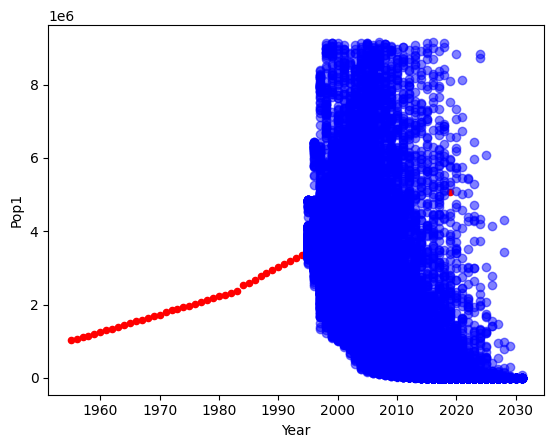

In [87]:
key = 2140
country_mdf = mdf[mdf['Country'] == key]
country_pdf = pdf[pdf['Country'] == key]
country_lnmrdf = lnmrdf[lnmrdf['Country'] == key]
country_lnfrdf = lnfrdf[lnfrdf['Country'] == key]
        
max_year = np.min([(country_lnmrdf['Year'].max(), country_lnfrdf['Year'].max(), country_pdf['Year'].max())])
country_pdf.plot(kind='scatter',x='Year',y='Pop1',color='red')    
        
year_range = int((pred_year - max_year))
curr_Year_array = []
total_pop_array = []
for i in mort_d[key]:
    for j in fert_d[key]:
        
        max_lnmrdf_row = country_lnmrdf[country_lnmrdf['Year'] == max_year].drop(columns=['Country', 'Year']).values
        max_lnfrdf_row = country_lnfrdf[country_lnfrdf['Year'] == max_year].drop(columns=['Country', 'Year']).values
        max_pdf_row = country_pdf[country_pdf['Year'] == max_year].drop(columns=['Country', 'Year', 'Pop1']).values[0]
        curr_Year = max_year
        population_array = []
        population_array.append(max_pdf_row[:5].sum())
        
        for ele in max_pdf_row[5:]:
            population_array.append(ele)
        
        population_array = np.array(population_array)
        
        for year in range (0, year_range-1):
            
            next_lnmrdf = i[year]
            next_lnfrdf = j[year]
            
            max_lnmrdf_row += next_lnmrdf
            actually_mr = np.diag(np.exp(max_lnmrdf_row)[0]) 
            max_lnfrdf_row += next_lnfrdf
            actually_fr = np.exp(max_lnfrdf_row)[0][0]

            total_pop = population_array.sum()
    
            deaths = population_array * actually_mr
            deaths = np.nan_to_num(deaths.diagonal()) 
            total_deaths = deaths.sum() 
            
            births = total_pop * actually_fr
            
            population_array[0] += births
            population_array -= deaths
            
            for ele in range(len(population_array)):
                if population_array[ele] < 0:
                    population_array[ele] = 0
            
            aged = population_array / 5
            population_array -= aged
            
            for ele in range (len(aged)-1):
                population_array[ele+1] += aged[ele]
                
            population_array = np.nan_to_num(population_array)  
            population_array[population_array == inf] = 0
            
            
            total_pop = population_array.sum()
            curr_Year += 1
            
            if total_pop == inf or total_pop == 0:
                break
            else:
                curr_Year_array.append(curr_Year)
                total_pop_array.append(total_pop)
                
            # plt.scatter(curr_Year, total_pop, color='blue')
            
    
        
  


total_pop_array = np.array(total_pop_array)
curr_Year_array = np.array(curr_Year_array)

q1 = np.quantile(total_pop_array, 0.25)
q3 = np.quantile(total_pop_array, 0.75)

iqr = q3 - q1
upperBound = q3 + 1.5 * iqr
lowerBound = q1 - 1.5 * iqr

indices = np.where((total_pop_array < lowerBound) | (total_pop_array > upperBound))[0]
indices_filter = [z for z,n in enumerate(total_pop_array) if z not in indices]

fixed_total_pop_array = total_pop_array[indices_filter]
fixed_curr_Year_array = curr_Year_array[indices_filter]

plt.scatter(fixed_curr_Year_array, fixed_total_pop_array, color='blue', alpha=0.5)